In [1]:
# !pip3 install yfinance --upgrade --no-cache-dir
!pip3 install yahoo_fin
!pip3 install multiprocess

! pip3 install pyarrow

# # ML packages
! pip3 install keras==2.4.3
! pip3 install tensorflow
# ! pip3 install sklearn
# ! pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import json
import pandas as pd
import numpy as np
from yahoo_fin import stock_info
import yahoo_fin
from multiprocessing import Pool
import multiprocess as mp
import datetime
from collections import Counter

import itertools
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from get_historical_data import get_historical_data
end_date = datetime.datetime.now().date()
start_date = end_date - datetime.timedelta(days=365 * 2)

def get_historical_data_batch(tickers, start_date, end_date):
    historical_data = []
    with Pool(32) as p:
        historical_data = p.map(get_historical_data, tickers)
    return historical_data


In [4]:

%%time
tickers = stock_info.tickers_sp500()

# a couple of hard-coded company->ticker values
company_to_ticker = {
    'Broadcom Inc.': 'AVGO',
    'AD': 'ADM',
    'ADDDYY': 'ADDYY',
    'AOBC': 'AOUT',
    'APCD': 'APCD.VI',
    'APPL': 'AAPL',
    'AZSEY': 'ALIZY',
    'BAMXY': 'BMWYY',
    'BBCBX': 'BBCPX',
    'BOA': 'BAC',
    'BRK.A': 'BRK-A',
    'BRK.B': 'BRK-B',
    'BXS$A': 'BXS-PA',
    'CCC': 'CLVT',
    'CTL': 'LUMN',
    'CWEN.A': 'CWEN-A',
    'DESY': 'DSEY',
    'EBJ': 'ERJ',
    'EQUIX': 'EFX',
    'EVGB': 'EVBG',
    'FFHRX': 'FFRHX',
    'FII': 'FHI',
    'FMCMF': 'FMS',
    'FXM': 'FMX',
    'GEAGY': 'GEAGF',
    'HCN': 'WELL',
    'HS': 'HSIC',
    'HTZ': 'HTZGQ',
    'IDXXX': 'IDXX',
    'INTL': 'INTC',
    'LAM': 'LRCX',
    'LBDAV': 'LBRDA',
    'LCRX': 'LRCX',
    'LEN.B': 'LEN-B',
    'LTD': 'LB',
    'MRCK': 'MRK',
    'MSBHY': 'MSBHF',
    'NGLS': 'NGL',
    'ORLT': 'ORLY',
    'POL': 'AVNT',
    'RBS': 'NWG',
    'RDS.A': 'RDS-A',
    'RDS.B': 'RDS-B',
    'RF$A': 'RF-A',
    'SERV': 'TMX',
    'SVCBY': 'SVCBF',
    'TDDC': 'TDC',
    'URGO': 'UGRO',
    'WFC$V': 'WFC',
    'WYND': 'TNL',
    'XMO': 'XOM',
    'ZOOM': 'ZM'
}

# '--' is the null ticker, remove it
if '--' in tickers:
    tickers.remove('--')

historical_data = get_historical_data_batch(tickers, start_date, end_date)


CPU times: user 763 ms, sys: 191 ms, total: 955 ms
Wall time: 10.8 s


In [15]:
%%time
# get a filter for some of the historical data
ticker_to_historical_data = {ticker_table['ticker'].iloc[0]: ticker_table.sort_values('date')
                             for ticker_table in historical_data if not isinstance(ticker_table, tuple)}

# first step. Build indexes
# is this the easiest way to build things? probably not
# but this is lightweight and is reasonably performant
unique_dates = sorted(set(itertools.chain.from_iterable([table['date'] for table in ticker_to_historical_data.values()])))
unique_dates = np.array(unique_dates, dtype='datetime64[D]')
date_to_index = {date: index for index, date in enumerate(unique_dates)}

ticker_to_index = {ticker: index for index, ticker in enumerate(sorted(list(ticker_to_historical_data.keys())))}

# initialize the data matrix to a bunch of zeros
ticker_data_matrix = np.zeros((len(tickers), len(unique_dates)), dtype=np.float)

# fill the matrix with data
for ticker, ticker_data_table in ticker_to_historical_data.items():
    ticker_index = ticker_to_index[ticker]
    ticker_dates = np.array(ticker_data_table['date'], dtype='datetime64[D]')
    date_indexes = np.array([date_to_index[cur_date] for cur_date in ticker_dates])
    price_data = ticker_data_table['close'].values
    ticker_data_matrix[ticker_index, date_indexes] = price_data

# there's some nan values in the data, write them as zero for now
ticker_data_matrix = np.nan_to_num(ticker_data_matrix)

CPU times: user 828 ms, sys: 5.03 ms, total: 833 ms
Wall time: 830 ms


In [16]:
%%time

# for the snp 500 data. It looks like the number of unique dates is different than the SNP 500 data...
# i.e., we don't invest on weekends...
log_price_matrix = np.copy(ticker_data_matrix)
log_price_matrix[np.where(log_price_matrix != 0)] = np.log(log_price_matrix[np.where(log_price_matrix != 0)])

# fit the log stuff with interpolation
x_values = np.array(list(range(log_price_matrix.shape[-1])))
for i, time_series in enumerate(log_price_matrix):
    mask = time_series != 0
    # if there are no non-zero values, give up
    if not np.any(mask):
        continue
    interp_x_values = x_values[mask]
    interp_y_values = time_series[mask]
    log_price_matrix[i] = np.interp(x_values, interp_x_values, interp_y_values)


CPU times: user 27.3 ms, sys: 13.4 ms, total: 40.7 ms
Wall time: 39.4 ms


In [17]:
# TODO: given some price range, compute all of the mean/variance terms

start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).date()
end_date = datetime.datetime.now().date()

print(start_date, end_date)

def compute_mean_variance(start_date, end_date):
    sorted_dates = sorted(date_to_index.keys())
    first_date_index = np.searchsorted(sorted_dates, start_date) + 1
    last_date_index = np.searchsorted(sorted_dates, end_date)
    print(first_date_index, last_date_index)
    date_matrix = log_price_matrix[:, first_date_index: last_date_index]
    date_diffs = date_matrix[:, 1:] - date_matrix[:, :-1]
    
    means = np.mean(date_diffs, axis=1)
    covariance = (np.dot(date_diffs, date_diffs.T) / (date_diffs.shape[1] ** 1)) - np.outer(means, means)

    return means, covariance

means, covariance = compute_mean_variance(start_date, end_date)


2020-09-15 2021-09-15
253 504


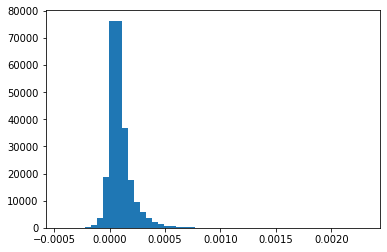

In [18]:
plt.hist(covariance.flatten(), bins=50)
plt.show()

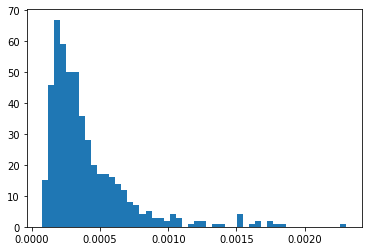

In [19]:
plt.hist(np.diag(covariance), bins=50)
plt.show()

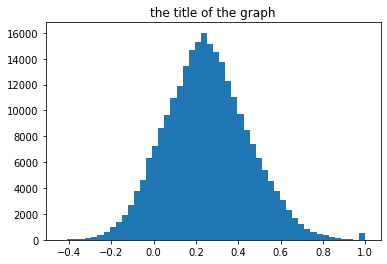

In [22]:
pearsons = [covariance[i, j] / np.sqrt(covariance[i, i] * covariance[j, j])
            for i in range(covariance.shape[0]) for j in range(covariance.shape[1])]
plt.hist(pearsons, bins=50)
plt.title('the title of the graph')
plt.show()

In [21]:
output_data = {
    'ticker_to_index': ticker_to_index,
    'mean_vector': means.tolist(),
    'covariance_matrix': covariance.tolist()
}

output_data = json.dumps(output_data, indent=4, sort_keys=True)

with open('tmp.txt', 'w') as file:
    file.write(output_data)
    file.flush()

In [ ]:
index_to_ticker = {v: k for k, v in ticker_to_index.items()}

lemon_data = historical_data[ticker_to_index['ETSY']].sort_values('date')

# 2021-05-29 2021-09-06
start_date = datetime.datetime(year=2021, month=5, day=29)
end_date = datetime.datetime(year=2021, month=9, day=6)
lemon_data[(lemon_data['date'] <= end_date) & (lemon_data['date']>= start_date)].sort_values('date')

In [ ]:
220.380005 / 163.460007

In [ ]:
index_to_ticker = {v: k for k, v in ticker_to_index.items()}

lemon_data = historical_data[ticker_to_index['LVS']].sort_values('date')

# 2021-05-29 2021-09-06
start_date = datetime.datetime(year=2021, month=5, day=29)
end_date = datetime.datetime(year=2021, month=9, day=6)
lemon_data[(lemon_data['date'] <= end_date) & (lemon_data['date']>= start_date)].sort_values('date')

In [ ]:
covariance[ticker_to_index['MRNA'], ticker_to_index['MRNA']]

In [ ]:
log_price_matrix[ticker_to_index['ETSY'], 436:503]

In [ ]:
5.39535335 - 5.16558565

In [ ]:
np.var(log_price_matrix[ticker_to_index['MRNA'], 436:503])

In [ ]:
np.var(np.diff(log_price_matrix[ticker_to_index['MRNA'], 436:503]))

In [ ]:
first_date_index, last_date_index = 436, 503

date_matrix = log_price_matrix[:, first_date_index: last_date_index]
date_diffs = date_matrix[:, 1:] - date_matrix[:, :-1]

mean_increase = date_diffs[:, -1] - date_diffs[:, 0]
mean_increase /= last_date_index - first_date_index

means = np.mean(date_diffs, axis=1)
covariance = (np.dot(date_diffs, date_diffs.T) / (date_diffs.shape[1] ** 1)) - np.outer(means, means)

In [ ]:
means[ticker_to_index['ETSY']]

In [ ]:
last_date_index - first_date_index